In [1]:
from Bio import SeqIO
from glob import glob
import os
import re

In [2]:
import numpy
numpy.__version__

'1.22.3'

In [3]:
from mito.genotyping_initial_rho import *

## Load reference

In [4]:
# Path to reference genome
reference_path = '../../data/reference/mito_GRCh38_gimlet.fasta'

with open(reference_path, 'r'):
    reference_seq = next(SeqIO.parse(reference_path, "fasta"))
reference = pd.Series(list(reference_seq.seq))

## Load read count matrices

In [5]:
# Path to allele count files
INPUT_PATH = '../../data/YFV2001_scRNAseq_sub1/'

In [6]:
cell_count = []

# Get all allele counts files in the input path
cell_count_filenames = list(glob(os.path.join(INPUT_PATH, '*.txt'))) #*.txt

for filename in sorted(cell_count_filenames):
    print('Reading {}'.format(filename))
    name = os.path.basename(filename).split('.')[0]
    

    # Load one allele count file
    counts = pd.read_csv(filename, sep='\t')
    counts.name = name
    cell_count.append(counts)
    
# Get sample order

sample_list = []

for filename in sorted(cell_count_filenames):
    name = os.path.basename(filename).split('-')[0]#.split('_')[-1]
    sample_list.append(name)

sample_list_df = pd.DataFrame(sample_list)
sample_list_df = sample_list_df.rename(columns={0: 'cell'})

Reading ../../data/YFV2001_scRNAseq_sub1/1_12_P3861_210.txt
Reading ../../data/YFV2001_scRNAseq_sub1/1_150312_BC6BFMANXX_P1902_1009_ac.txt
Reading ../../data/YFV2001_scRNAseq_sub1/1_150312_BC6BFMANXX_P1902_1029_ac.txt
Reading ../../data/YFV2001_scRNAseq_sub1/1_150312_BC6BFMANXX_P1902_1047_ac.txt
Reading ../../data/YFV2001_scRNAseq_sub1/1_150312_BC6BFMANXX_P1902_1051_ac.txt
Reading ../../data/YFV2001_scRNAseq_sub1/1_150312_BC6BFMANXX_P1902_1065_ac.txt
Reading ../../data/YFV2001_scRNAseq_sub1/1_150312_BC6BFMANXX_P1902_1075_ac.txt
Reading ../../data/YFV2001_scRNAseq_sub1/1_150312_BC6BFMANXX_P1902_1082_ac.txt
Reading ../../data/YFV2001_scRNAseq_sub1/1_150312_BC6BFMANXX_P1902_1087_ac.txt
Reading ../../data/YFV2001_scRNAseq_sub1/1_150312_BC6BFMANXX_P1902_1094_ac.txt
Reading ../../data/YFV2001_scRNAseq_sub1/2_140812_AC492YACXX_P1299_1141_ac.txt
Reading ../../data/YFV2001_scRNAseq_sub1/2_140812_AC492YACXX_P1299_1160_ac.txt
Reading ../../data/YFV2001_scRNAseq_sub1/2_150312_BC6BFMANXX_P1902_1099

# Compute mutations probabilities

In [7]:
def cell_prob(e_rate):
    
    error_rate_when_no_mutation = error_rate_when_mutation = e_rate
    p_mutation = 1 / 500.0

    cell_prob = []
    for count in cell_count:
        count = count.iloc[:reference.shape[0]]  # discard trailing positions
        p = nucleotide_mutation_prob(
            cell_counts=count,
            reference=reference,
            error_rate_when_no_mutation=error_rate_when_no_mutation,
            #error_rate_when_no_mutation= e_rate / 3,
            error_rate_when_mutation=error_rate_when_mutation,
            #error_rate_when_mutation= e_rate / 3,
            p_mutation=p_mutation,
        )

        cell_prob.append(p)
        
    # Compute P(mutation | read counts)
    cells_p_mutation = []
    for cell_prob in cell_prob:
        p = mutation_prob(cell_prob, reference)
        cells_p_mutation.append(p)
        
        
    # Make mutation matrix
    mutation_matrix = cells_p_mutation[0][['#CHR', 'POS']].copy()
    mutation_matrix_data = pd.DataFrame(np.dstack([c['Prob_mutation'].values for c in cells_p_mutation]).squeeze())
    mutation_matrix = pd.concat([mutation_matrix, mutation_matrix_data], axis=1)

    return mutation_matrix


# Filter pmat

## Find postions with low average coverage

In [8]:
def remove_low_cov_pos(cell_count):
    
    # Filter positions with low mean coverage
    
    # First make list with positions with low coverage
    
    # concat cell counts into new df
    cc_flt = pd.concat(cell_count, axis=1)
    # drop unwanted cols
    cc_flt.drop(['#CHR', 'POS', 'Count_A', 'Count_C', 'Count_G', 'Count_T'], axis=1, inplace=True)
    # drop bulk col
    column_numbers = [x for x in range(cc_flt.shape[1])] # list of columns' integer indices
    column_numbers.remove(0) #removing column integer index 0
    cc_flt = cc_flt.iloc[:, column_numbers] #return all columns except the 0th column
    
    # compute average coverage
    cc_flt['mean'] = cc_flt.mean(axis=1)
    
    # Get positions in new col
    cc_flt.reset_index(inplace=True)
    cc_flt['POS'] = cc_flt['index']+1
    
    # make new df with only relevant info
    cc_flt_pos = cc_flt[['mean', 'POS']]
    
    # reset index
    cc_flt_pos.set_index('POS', inplace=True)
    
    # Select rows with low coverage
    threshold = 100
    below_thres = cc_flt_pos.loc[cc_flt_pos['mean'] < threshold]

    # save index (which is POS) to list
    below_thres_lst = below_thres.index.tolist()
    
    return below_thres_lst

In [9]:
below_thres_lst = remove_low_cov_pos(cell_count)
len(below_thres_lst)

4476

## Filter pmat

In [10]:
def flt_pmat(e_rate, cell_count):
    mutation_matrix = cell_prob(e_rate)

    # Remove germline mutations
    mutation_matrix = mutation_matrix.loc[mutation_matrix[0] < 0.9]
    
    # Probabilities for location with mutation at any of the cells
    mutation_threshold = 0.9
    data = mutation_matrix.set_index('POS').drop('#CHR', axis=1)
    mutation_any_cell = data[(data > mutation_threshold).any(axis=1)]
    
    # select rows that have a value greater than mutation_threshold in more than x cells
    mutation_threshold = 0.9
    mask = (data.values > mutation_threshold).sum(axis=1) > 1 #create an array with boolean values and sum these along the axis and select rows with more than 1 True
    two_cells_have_mut = data[mask]

    # Define size of 50% of the population
    half = len(two_cells_have_mut.columns) / 2

    # Remove rows where 50% of cols are nan and save in new df
    nan_rows = two_cells_have_mut.drop(two_cells_have_mut[(two_cells_have_mut.isna()).sum(axis=1)> half].index)

    # Replace NaN with row mean
    imputed = nan_rows.transpose().fillna(nan_rows.mean(axis=1)).transpose()
    
    # To skip removal of sites with overall high probability for mut
    #high_prob_rows = imputed.copy()
    
    # remove locations close to another location
    index = imputed.index.tolist() + [2000000]
    ind = [ a for a,b in zip(index[:-1], index[1:]) if b-a > 4]
    clust = imputed.loc[ind]
    #clust.shape
    
    # Replace 1.0
    replaced = clust.replace(1.0, 0.99999)
        
    # Remove pos with low cov
    below_thres_lst = remove_low_cov_pos(cell_count)
    
    low_dp = replaced.copy()
    low_dp.reset_index(inplace = True)
    low_dp = low_dp[~low_dp['POS'].isin(below_thres_lst)]
    low_dp.set_index('POS', inplace=True)
    
    shape = low_dp.shape

    # save matrix
    #np.set_printoptions(suppress=True)
    #e_rate_name = str(e_rate)
    #matrix_path = '../../data/YFV2001_matrix_output_initial_rho/' + e_rate_name + '.csv'
    #matrix_path = '../../data/YFV2001_matrix_output_initial_rho_div3/' + e_rate_name + '.csv'
    #low_dp.to_csv(matrix_path, index=False, sep=' ', header= False)
    
    #return e_rate
    
    return e_rate, shape
    
    


In [11]:
# Error rates to run
e_rates = [0.01 ,0.02 ,0.03 ,0.04 ,0.05 ,0.06 ,0.07, 0.08 , 0.09, 0.1, 0.2]

In [12]:
# (2)
# Initial rho

# _log_prob_ABC_no_mutation
# error_rate = error_rate / 3

# _log_prob_ABC_with_mutation_at_A
# error_rate = error_rate / 2


import warnings
warnings.filterwarnings('ignore')

for e_rate in e_rates:
    #print(e_rate)
    e_rate = e_rate
    #e_rate = e_rate/3
    error_rate, shape = flt_pmat(e_rate, cell_count)
    print(error_rate)
    print(shape)

0.01
(109, 73)
0.02
(70, 73)
0.03
(54, 73)
0.04
(48, 73)
0.05
(43, 73)
0.06
(41, 73)
0.07
(40, 73)
0.08
(39, 73)
0.09
(39, 73)
0.1
(38, 73)
0.2
(10, 73)


In [12]:
# (3)
# Initial rho
# cell_prob(e_rate)
# error_rate_when_no_mutation= e_rate / 3
# error_rate_when_mutation= e_rate / 2


import warnings
warnings.filterwarnings('ignore')

for e_rate in e_rates:
    #print(e_rate)
    e_rate = e_rate
    #e_rate = e_rate/3
    error_rate, shape = flt_pmat(e_rate, cell_count)
    print(error_rate)
    print(shape)

0.01
(109, 73)
0.02
(70, 73)
0.03
(54, 73)
0.04
(48, 73)
0.05
(43, 73)
0.06
(41, 73)
0.07
(40, 73)
0.08
(39, 73)
0.09
(39, 73)
0.1
(38, 73)
0.2
(10, 73)


In [12]:
# (4)
# Initial rho
# cell_prob(e_rate)
# error_rate_when_no_mutation= e_rate / 3
# error_rate_when_mutation= e_rate / 3


import warnings
warnings.filterwarnings('ignore')

for e_rate in e_rates:
    #print(e_rate)
    e_rate = e_rate
    #e_rate = e_rate/3
    error_rate, shape = flt_pmat(e_rate, cell_count)
    print(error_rate)
    print(shape)

0.01
(130, 73)
0.02
(1, 73)
0.03
(0, 73)
0.04
(0, 73)
0.05
(0, 73)
0.06
(0, 73)
0.07
(0, 73)
0.08
(0, 73)
0.09
(0, 73)
0.1
(0, 73)
0.2
(0, 73)


In [12]:
# (5)
# Initial rho
# flt_pmat
# e_rate = e_rate/3


import warnings
warnings.filterwarnings('ignore')

for e_rate in e_rates:
    #print(e_rate)
    #e_rate = e_rate
    e_rate = e_rate/3
    error_rate, shape = flt_pmat(e_rate, cell_count)
    print(error_rate)
    print(shape)

0.0033333333333333335
(130, 73)
0.006666666666666667
(1, 73)
0.01
(0, 73)
0.013333333333333334
(0, 73)
0.016666666666666666
(0, 73)
0.02
(0, 73)
0.023333333333333334
(0, 73)
0.02666666666666667
(0, 73)
0.03
(0, 73)
0.03333333333333333
(0, 73)
0.06666666666666667
(0, 73)


In [ ]:
rho3 = pd.read_csv('../../data/YFV2001_matrix_output_initial_rho_div3/0.0033333333333333335.csv', header=None, sep=' ')
rho3

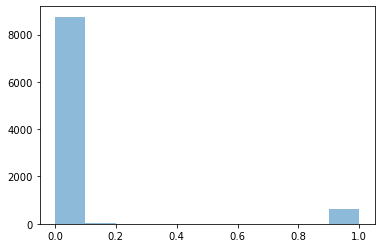

In [77]:
import matplotlib.pyplot as plt

values = np.ravel(rho3)
plt.hist(values, bins=10, alpha=0.5)
plt.show()

#rho3.plot.hist(bins=22, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

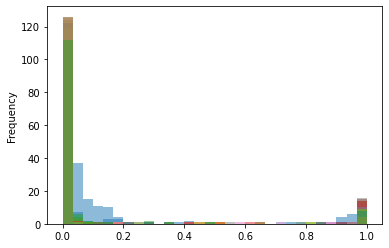

In [76]:
rho.plot.hist(bins=30, alpha=0.5, legend=None)


# Run mt-SCITE

In [18]:
# Check n samples
a_pmat = pd.read_csv('../../data/YFV2001_matrix_output_our_rho/0.01.csv', sep=' ', header=None)
a_pmat.shape

(109, 73)

In [19]:
# prepare pmat data

pmat_names = []
shapes = []

pmat_input_path = f'../../data/YFV2001_matrix_output_our_rho/'
#print(pmat_input_path)
pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))
tree_name = []

for filename in sorted(pmats, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
    name = os.path.basename(filename).split('-')[0].rsplit('.', 1)[0]
    #print(name)
    pmat_names.append(name)
    df = pd.read_csv(filename, sep=' ', header=None)
    shapes.append(len(df))

# make df with pmat info
pmat_data = pd.DataFrame(
    {'pmat_names': pmat_names,
     'len': shapes,
    })

pmat_data

,pmat_names,len
0,0.1,38
1,0.01,109
2,0.2,10
3,0.02,70
4,0.03,54
5,0.04,48
6,0.05,43
7,0.06,41
8,0.07,40
9,0.08,39


In [20]:
# Run mt-SCITE

SCITE_PATH = '../../../mt-SCITE'
PMAT_PATH = f'../../data/YFV2001_matrix_output_our_rho/'
OUTPUT = f'../../../mt-SCITE/mt-SCITE_output/YFV2001_our_rho/'

n_cells = '73'

for rep in range(1,2): #11
    
    for pmat in pmat_names:        
        run_id = pmat + '_' + str(rep)
        print('Running tree inference for error rate ' + pmat + ' repetition ' + str(rep))

        # Get number of mutations
        n = pmat_data.loc[pmat_data['pmat_names'] == pmat, 'len'].iloc[0].astype(str)

        try:
            os.makedirs(OUTPUT + '/stdout/') 
        except FileExistsError :
            pass
        except :
            raise

        ! $SCITE_PATH/mt-SCITE/scite -i $PMAT_PATH/$pmat\.csv -n $n -m $n_cells -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o $OUTPUT/$run_id 1> $OUTPUT/stdout/$run_id\.stdout.txt
        
        

Running tree inference for error rate 0.1 repetition 1
Running tree inference for error rate 0.01 repetition 1
Running tree inference for error rate 0.2 repetition 1
Running tree inference for error rate 0.02 repetition 1
Running tree inference for error rate 0.03 repetition 1
Running tree inference for error rate 0.04 repetition 1
Running tree inference for error rate 0.05 repetition 1
Running tree inference for error rate 0.06 repetition 1
Running tree inference for error rate 0.07 repetition 1
Running tree inference for error rate 0.08 repetition 1
Running tree inference for error rate 0.09 repetition 1
